In [122]:
# 실험 이름
model_name = 'exp2'
result_dir = '/content/drive/MyDrive/result1/%s/' % model_name

# 분석 환경 준비

In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


오디오 전처리를 위한 라이브러리

In [124]:
import librosa 
import librosa.display as dsp
from IPython.display import Audio

데이터 전처리를 위한 라이브러리

In [125]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

GPU 할당

In [126]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU 할당
print(device)

cuda


모델의 재현성을 위해 random seed 고정

In [127]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(929)

# 데이터 불러오기

In [128]:
train_X_save_load = np.load("/content/drive/MyDrive/data/train_X_SAVE.npy")
valid_X_save_load = np.load("/content/drive/MyDrive/data/valid_X_SAVE.npy")
train_y_save_load = np.load("/content/drive/MyDrive/data/train_y_SAVE.npy")
valid_y_save_load = np.load("/content/drive/MyDrive/data/valid_y_SAVE.npy")

### CustomDataset

In [129]:
import torchvision.datasets as datasets # 데이터셋 집합체
import torchvision.transforms as transforms # 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.X = X
        self.y = y
        self.train_mode = train_mode
        self.transforms = transforms

    def __getitem__(self, index): #index번째 data를 return
        X = self.X[index]
        
        if self.transforms is not None:
            X = self.transforms(X)

        if self.train_mode:
            y = self.y[index]
            return X, y
        else:
            return X
    
    def __len__(self): #길이 return
        return len(self.X)

# 모델 구조 정의

In [130]:
from tqdm.auto import tqdm
import torch
import torch.nn as nn # 신경망들이 포함됨

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 7), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 5), stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=(1, 0)), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) #pooling layer
        
        self.dropout = nn.Dropout()
        
        self.relu = nn.ReLU()

        self.fc_layer1 = nn.Sequential( 
            nn.Linear(640, 640), #fully connected layer(ouput layer)
        )

        self.fc_layer2 = nn.Sequential( 
            nn.Linear(640, 256), #fully connected layer(ouput layer)
        )    

        self.fc_layer3 = nn.Sequential( 
            nn.Linear(256, 6), #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x.float()) #1층

        x = self.layer2(x) #2층

        x = self.dropout(x)

        x = self.layer3(x) #3층

        x = self.dropout(x)

        x = self.layer4(x) #4층

        x = self.dropout(x)

        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열

        x = self.relu(self.fc_layer1(x))

        x = self.dropout(x)

        x = self.relu(self.fc_layer2(x))

        x = self.dropout(x)

        out = self.fc_layer3(x)
        return out

# 모델 학습

In [131]:
import matplotlib.pyplot as plt

def fit(train_X, train_y, valid_X, valid_y, mfcc_y, epochs, batch_size):

    train_data = CustomDataset(X=train_X, y=train_y)
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

    valid_data = CustomDataset(X=valid_X, y=valid_y)
    valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle=False)


    model = CNNclassification().to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-2 )
    scheduler = None

    model(torch.rand(batch_size, 1, 40, mfcc_y).to(device))

    train(model, criterion, optimizer, train_loader, valid_loader, scheduler, device, epochs)

def train(model, criterion, optimizer, train_loader, valid_loader, scheduler, device, epochs): 

    print('\n------------ training start ---------------')

    train_loss = []
    val_loss = []

    train_acc = []
    val_acc = []

    model.to(device)
    n = len(train_loader)
    best_acc = 0
    
    for epoch in range(1, epochs + 1): #에포크 설정
        model.train() #모델 학습
        running_loss = 0.0
        
        correct = 0
        for wav, label in iter(train_loader):
            
            wav, label = wav.to(device), label.to(device) #배치 데이터
            optimizer.zero_grad() #배치마다 optimizer 초기화
        
            # Data -> Model -> Output
            logit = model(wav) #예측값 산출
            loss = criterion(logit, label) #손실함수 계산
            pred = logit.argmax(dim=1, keepdim=True)  #10개의 class중 가장 값이 높은 것을 예측 label로 추출
            correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
            
            # 역전파
            loss.backward() #손실함수 기준 역전파 
            optimizer.step() #가중치 최적화
            running_loss += loss.item()
             
        print('[%d] Train loss: %.10f' %(epoch, running_loss / len(train_loader)))

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / len(train_loader.dataset))

        if scheduler is not None:
            scheduler.step()
            
            
        #Validation set 평가
        model.eval() #evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
        vali_loss = 0.0
        correct = 0
       
        with torch.no_grad(): #파라미터 업데이트 안하기 때문에 no_grad 사용
            for wav, label in iter(valid_loader):
                
                wav, label = wav.to(device), label.to(device)
                logit = model(wav)
                vali_loss += criterion(logit, label).item()
                pred = logit.argmax(dim=1, keepdim=True)  #10개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
        vali_acc = 100 * correct / len(valid_loader.dataset)
        print('Vali set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(vali_loss / len(valid_loader), correct, len(valid_loader.dataset), 100 * correct / len(valid_loader.dataset)))
        
        val_loss.append(vali_loss / len(valid_loader))
        val_acc.append(correct / len(valid_loader.dataset))

        #베스트 모델 저장
        if best_acc < vali_acc:
            best_acc = vali_acc

            if not os.path.exists(result_dir):
                os.makedirs(result_dir)

            torch.save(model.state_dict(), result_dir + 'model.pth') #이 디렉토리에 best_model.pth을 저장
            print('Model Saved.')
        
    
    def draw_result(train, val, mode=0):
        x = np.arange(1, epochs + 1, 1)

        plt.plot(x, train, label='train')
        plt.plot(x, val, label='validation')

        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy' if mode == 0 else 'loss')

        plt.legend()
        
        if mode == 0:
            plt.savefig(result_dir + 'accuarcy.png')
        else:
            plt.savefig(result_dir + 'loss.png')

    draw_result(train_acc, val_acc)
    plt.clf()
    draw_result(train_loss, val_loss, 1)


------------ training start ---------------
[1] Train loss: 1.7310532888
Vali set: Loss: 1.5216, Accuracy: 155/300 ( 52%)

Model Saved.
[2] Train loss: 1.3439782524
Vali set: Loss: 1.3200, Accuracy: 137/300 ( 46%)

[3] Train loss: 1.1029445275
Vali set: Loss: 0.9241, Accuracy: 205/300 ( 68%)

Model Saved.
[4] Train loss: 0.7686646656
Vali set: Loss: 0.6688, Accuracy: 249/300 ( 83%)

Model Saved.
[5] Train loss: 0.5907398355
Vali set: Loss: 0.5524, Accuracy: 245/300 ( 82%)

[6] Train loss: 0.5622733502
Vali set: Loss: 0.5115, Accuracy: 251/300 ( 84%)

Model Saved.
[7] Train loss: 0.4822986013
Vali set: Loss: 0.4754, Accuracy: 263/300 ( 88%)

Model Saved.
[8] Train loss: 0.4200613783
Vali set: Loss: 0.3831, Accuracy: 275/300 ( 92%)

Model Saved.
[9] Train loss: 0.3565891316
Vali set: Loss: 0.5027, Accuracy: 235/300 ( 78%)

[10] Train loss: 0.3558661060
Vali set: Loss: 0.3231, Accuracy: 276/300 ( 92%)

Model Saved.
[11] Train loss: 0.2985822584
Vali set: Loss: 0.2633, Accuracy: 281/300 (

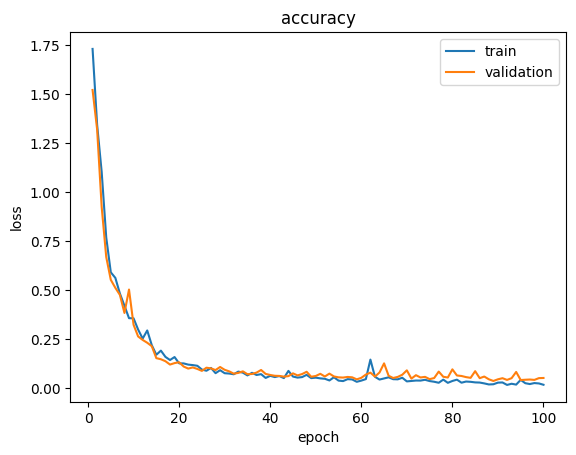

In [132]:
fit(train_X_save_load, train_y_save_load, valid_X_save_load, valid_y_save_load, train_X_save_load.shape[3], 100, 32)

# Test set 전처리

In [133]:
def test_dataset():
    dataset = []
    for file in tqdm(os.listdir('/content/drive/MyDrive/data/test'),colour='green'):
        if 'wav' in file:
            abs_file_path = os.path.join('/content/drive/MyDrive/data/test',file)
            data, sr = librosa.load(abs_file_path, sr = 44100)
            
            dataset.append([data, file])
    
    print("Test Dataset 생성 완료")
    return pd.DataFrame(dataset,columns=['data', 'file_name'])

In [134]:
test_wav = test_dataset()

  0%|          | 0/300 [00:00<?, ?it/s]

Test Dataset 생성 완료


In [135]:
def set_length(data):

    print('set length')

    length = 4 * 44100

    result = []
    for i in tqdm(data):

        if len(i) > length:
            arr = i[:length]
        else:
            arr = np.pad(i, (0, length - len(i)), mode='constant', constant_values=0)
        
        result.append(arr.tolist())
        
    result = np.array(result)

    return result

In [136]:
def preprocess_dataset(data):
    mfccs = []
    for i in data:
        extracted_features = librosa.feature.mfcc(y=i,
                                              sr=44100,
                                              n_mfcc=40)
        mfccs.append(extracted_features)
            
    mfccs = np.array(mfccs)

    return mfccs.reshape(-1, 1, mfccs.shape[1], mfccs.shape[2])

# 모델 평가

In [137]:
# 사이킷런 #
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import seaborn as sns

# 결과 출력
def result(df,preds,expInfo=None): # 결과 생성 
    # 답안지, 정답지 생성
    df['answer'] = 0
    df['predict'] = preds

    #파일 이름에서 라벨 추출
    df.loc[df['file_name'].str.contains('A_01_'), 'answer'] = 0
    df.loc[df['file_name'].str.contains('A_02_'), 'answer'] = 1
    df.loc[df['file_name'].str.contains('A_03_'), 'answer'] = 2
    df.loc[df['file_name'].str.contains('B_01_'), 'answer'] = 3
    df.loc[df['file_name'].str.contains('B_02_'), 'answer'] = 4
    df.loc[df['file_name'].str.contains('B_03_'), 'answer'] = 5
    df['answer'] = df['answer'].astype(int)  # 정답(aswer) colum을 정수형으로 변환
    
    answer_arr = df['answer'].tolist()
    # anslist_arr=np.array(anslist)  # 정답 넘파이 배열
    # preds_arr=np.array(preds) # 예측 넘파이 배열
    

    ''' 평가용 결과 출력'''
    import os
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    """1. Confusion_matrix 출력"""
    cm = confusion_matrix(answer_arr,preds) # 정답(x축)값, 예측(Y축)값을 이용하여 Confusion Matrix 계산
    plt.title('Confusion Matrix') # 제목 추가
    sns.heatmap(cm, annot=True, cmap='Blues') # 도시
    plt.savefig('%sconfusion_matrix_%s.png'%(result_dir, expInfo)) # 그래프를 이미지 파일로 저장


    """2. 상세 로그 저장 """
    df.drop('data',axis=1,inplace=True)  # 소리 데이터 제거
    df.to_csv("%sTest_evaluation_all_%s.csv" % (result_dir, expInfo), index=False) # data frame 

    
    for i in range(len(preds)):
        if df['answer'][i]==df['predict'][i]:
            df=df.drop(i, axis=0)
    # rs=df.drop_duplicates(subset=['answer', 'predict'], inplace=False) # 오분류 사례만 추출
    df.to_csv("%sTest_evaluation_error_case_%s.csv"%(result_dir, expInfo), index=False) # data frame 


    """3. 보고서 생성 및 저장"""
    # 예측값과 실제값을 이용하여 정확도 계산
    acc = accuracy_score(answer_arr,preds)
    acc_report = "%s 모델의 Test 정확도 (합산) : "%model_name+'{:.4f}'.format(acc)
    print(acc_report)  #결과 출력

    with open("%s/acuracy_report.txt" %result_dir , "w", encoding='utf-8') as f:
        f.write(acc_report)

    # 분류 보고서 생성
    report = classification_report(answer_arr,preds)
    print(report)

    # 결과를 txt로 저장
    with open("%s/classification_report_%s.txt" %(result_dir,expInfo), "w") as f:
        f.write(report)

In [138]:
def predict(model, test_loader, device):
    
    model.eval()
    model_pred = []
    with torch.no_grad():
        for wav in tqdm(iter(test_loader)):
            wav = wav.to(device)

            pred_logit = model(wav)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [139]:
def evaluation_all(test_wav):
    test_x = np.array(test_wav.data)
    test_x = set_length(test_x)
    test_X = preprocess_dataset(test_x)

    test_data = CustomDataset(X=test_X, y= None, train_mode=False)
    test_loader = DataLoader(test_data, batch_size = 32, shuffle=False)


    checkpoint = torch.load(result_dir + 'model.pth')
    model = CNNclassification().to(device)
    model.load_state_dict(checkpoint)


    # Inference
    preds = predict(model, test_loader, device)
    df = test_wav.copy()
    del test_wav
    result(df,preds,expInfo=model_name)

set length


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

exp2 모델의 Test 정확도 (합산) : 0.8000
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       0.81      0.96      0.88        50
           2       0.71      0.60      0.65        50
           3       0.97      0.66      0.79        50
           4       0.88      0.90      0.89        50
           5       0.83      0.68      0.75        50

    accuracy                           0.80       300
   macro avg       0.82      0.80      0.79       300
weighted avg       0.82      0.80      0.79       300



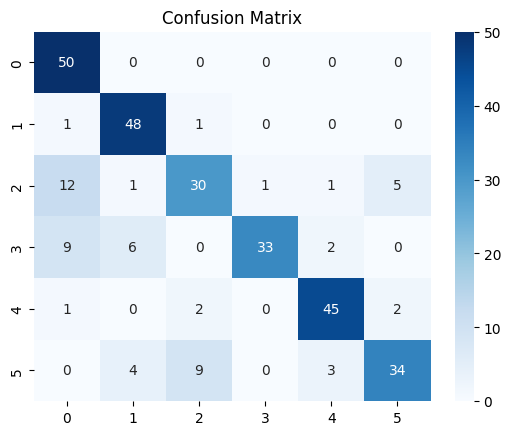

In [140]:
evaluation_all(test_wav)